In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get the current working directory + desired directory
parent_directory = os.getcwd()
main_directory = parent_directory + '/drive/MyDrive/2024 UW ENGINE Capstone'
curr_directory = main_directory + '/data/GMD and GIC'

In [8]:
import os
import pandas as pd
eventDate = 20131002  # Given

# Location DataFrame setup
loc_file = curr_directory + '/event_' + str(eventDate) + '/GIC/gic_monitors.csv'
loc_df = pd.read_csv(loc_file)  # Create DataFrame for locations based on device ID
time_column = 'SampleDateTime'
gic_column = 'GICMeasured'
# Adjusting Longitude values
loc_df.rename(columns={' Latitude': 'Latitude', ' Longitude': 'Longitude'}, inplace=True)
loc_df['Longitude'] = loc_df['Longitude'] * -1
device_IDs = loc_df['Device ID']

# Generate file paths
file_paths = [curr_directory + '/event_' + str(eventDate) + '/GIC/' + str(eventDate)[0:4] + 'E02_' + str(id) + '.csv' for id in loc_df['Device ID']]

# Filter files based on GICMeasured criteria
selected_files = []
for file_path in file_paths:
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        max_value = df[gic_column].max()
        min_value = df[gic_column].min()

        # Select files based on specified conditions
        if (max_value - min_value) >= 3 or max_value > 5:
            selected_files.append(file_path)

# #(Optional) Remove files not meeting the criteria
# for file_path in file_paths:
#     if file_path not in selected_files:
#         os.remove(file_path)
#         print(f"Removed: {file_path}")

#Continue with your processing for selected_files instead of file_paths
print("Selected files for processing:")
for file in selected_files:
    print(file)

Selected files for processing:
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10056.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10075.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10222.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10299.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10300.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10301.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10318.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10319.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and GIC/event_20131002/GIC/2013E02_10320.csv
/content/drive/MyDrive/2024 UW ENGINE Capstone/data/GMD and 

In [5]:
filtered_loc_df = loc_df[loc_df['Device ID'].isin(device_IDs)]

# A dict for storing resampled data
resampled_data = {}

# Extract the time and determine the common time point for each GIC file
for file_path, latitude, id in zip(selected_files, filtered_loc_df['Latitude'], filtered_loc_df['Device ID']):
    df = pd.read_csv(file_path, usecols=[time_column, gic_column]) # read the data .csv file
    df[time_column] = pd.to_datetime(df[time_column]) # convert to pandas format
    # Set the datetime object as an index
    df.set_index(time_column, inplace=True)
    # Store resampling data for each file (key, value)
    resampled_data[id] = df.resample('T').mean().interpolate(method='spline', order=3)  # 'T' stands for every minute


In [6]:
detail_coeffs_list = {}

# Conduct Haar wavedecomposition of GIC data
for i, id in zip(selected_files, filtered_loc_df['Device ID']):
    data = resampled_data[id]
    coeffs = pywt.wavedec(data[gic_column], 'haar', level=2)
    detail_coeffs_list[id] = np.abs(coeffs[1])

original_index = resampled_data[device_IDs[0]].index

new_index = original_index[::4]

new_time_str = new_index.strftime('%Y-%m-%d %H:%M:%S').tolist()

# Create the time frame GIC coefficients
df_gic = pd.DataFrame(detail_coeffs_list, index=new_time_str)

print(df_gic)

# 转置 DataFrame
df_transposed = df_gic.transpose()

df_transposed.index.name = 'Device ID'
df_transposed.columns.name = 'Time'
# print(df_transposed.head())

KeyError: 10056

<Axes: xlabel='Time', ylabel='Device ID'>

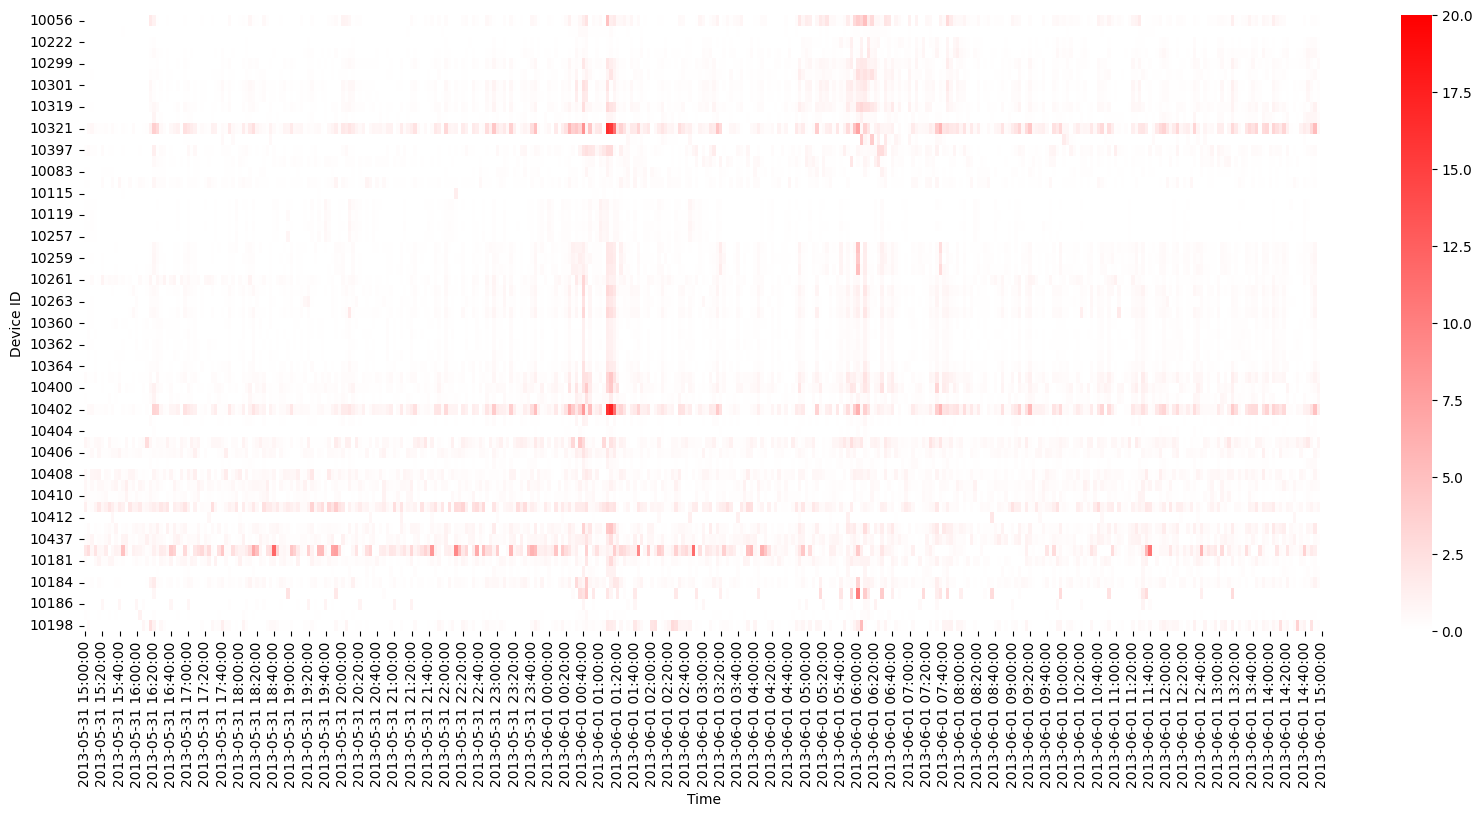

In [ ]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

colors = ["white", "red"]
cmap = LinearSegmentedColormap.from_list("custom_cmap",colors)
sns.set_context({"figure.figsize":(20,8)})
sns.heatmap(data=df_transposed,vmin=0, vmax=20,cmap=cmap)